In [12]:
import numpy as np
import scipy.linalg as sla
import matplotlib.pyplot as plt
import data_gen

# Gaussian Process Regression

A Gaussian process builds a surrogate model for a model too expensive to call loads of times. It extends a multivariate Gaussian to infinite dimensions, meaning random variables $x$ becomes random functions $f(x)$. The mean of the variables $\mu$ becomes a mean function $m(x)$ and rather than a covariance matrix $\Sigma_{ij}$ we have a covariance function $\textbf{k}(x_i, x_j)$.
### Covariance functions
There are quite a few covariance functions, but the one we'll use is the squared exponential covariance function - RBFs - 
$$
k(\textbf{x}, \textbf{x'}) = v\text{exp}\left[-\frac{1}{2} \sum^d_{i=1} \frac{(x_i-x_i')^2}{\ell^2_i} \right],
$$
where $v,\ell_i >0, i=1, ..., d$ are hyperparameters. <br>
For each of these covariance functions, $v$ is known as the $\textbf{signal variance}$ or $\textbf{signal strength}$. The bigger it is, the more the GP $f(x)$ will vary about the mean.

### Algorithm


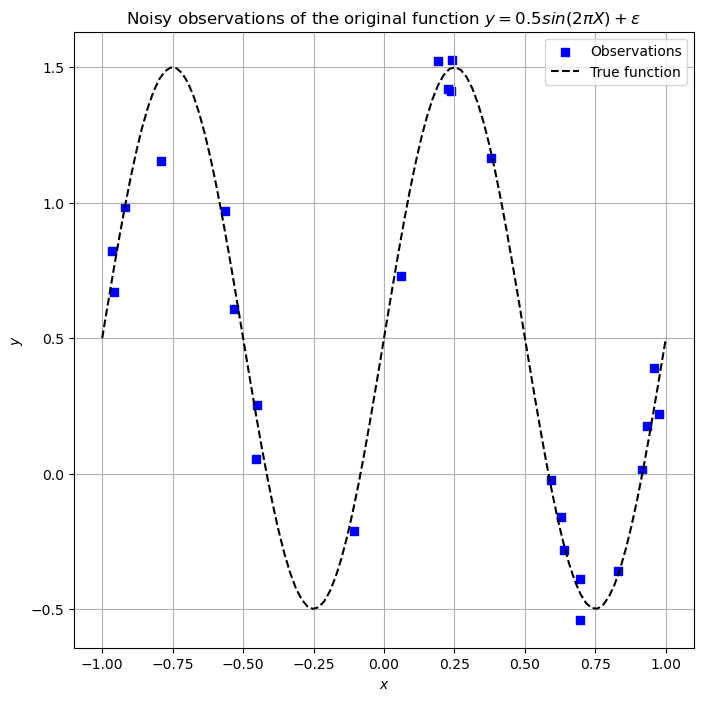

In [19]:
X_true = np.linspace(-1, 1, 100)
num_obvs = 25
sigma = 0.1
X_data = np.random.uniform(-1, 1, num_obvs)
y_data = data_gen.data(X_data, sigma**2)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_data, y_data, marker='s', label='Observations', color="b")
ax.plot(X_true, data_gen.sinusoid(X_true), label='True function', color="k", linestyle='--')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title("Noisy observations of the original function $y = 0.5 sin(2\pi X) + \epsilon$")
ax.legend()
ax.grid(True)

#### Define RBF

In [9]:
def RBF(x0: np.array, x1: np.array, ell: float, v: float) -> np.array:
    summs = -0.5 * np.sum(((x0 - x1)**2)/ell**2)
    return v * np.exp(summs)
# Define covariance function
ell = 0.2
v = 1
k = lambda x, y: RBF(x, y, ell, v)

### Form a Gaussian Process Model [1]

In [23]:
def GPR(X: np.array, y: np.array, k, sigma):
    N = y.size
    
    K = np.zeros((N, N))
    kstar = np.zeros(N)
    for i in range(N):
        for j in range(0, i+1):
            K[i, j] = k(X[i], X[j])
            if i!=j:
                K[j, i] = K[i, j]
            else:
                K[i, j] += sigma**2
                
    # Cholesky Factorisation
    L = np.linalg.cholesky(K)
    alpha = sla.solve_triangular(L.T, sla.solve_triangular(L, y, lower=True))
    f_star = kstar.T @ alpha
    v = sla.solve_triangular(L, kstar, lower=True)
    V_star = kstar - v.T @ v
    
    return f_star, V_star

In [27]:
y_star, V = GPR(X_data, y_data, k, sigma)
print(y_star)
sigma_epi = np.sqrt(np.diag(V)).flatten() # epistemic uncertainty: posterior variance from GP
sigma_tot = np.sqrt(np.diag(V) + sigma**2).flatten() # posterior variance + noise

0.0


ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

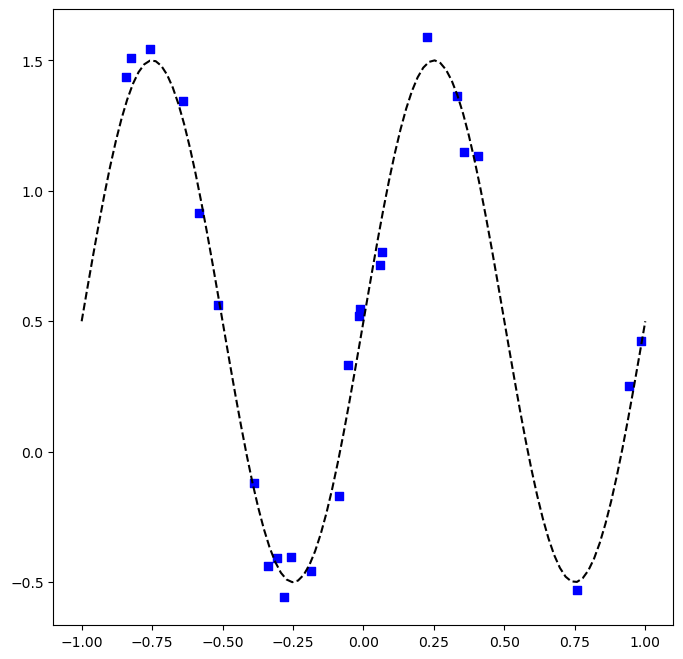

In [26]:
X_true = np.linspace(-1, 1, 100)
num_obvs = 25
sigma = 0.1
X_data = np.random.uniform(-1, 1, num_obvs)
y_data = data_gen.data(X_data, sigma**2)
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X_data, y_data, marker='s', label='Observations', color="b")
ax.plot(X_true, data_gen.sinusoid(X_true), label='True function', color="k", linestyle='--')
ax.plot(X_true, y_star.flatten(), label='GPR prediction', color="r", linestyle='--')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title("Noisy observations of the original function $y = 0.5 sin(2\pi X) + \epsilon$")
ax.legend()
ax.grid(True)

## References
[1. Uncertainty Quantification and Predictive Computational Science, pg 270, 271](https://link.springer.com/book/10.1007/978-3-319-99525-0)